In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data29776


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
import numpy
import paddle
import paddle.fluid as fluid
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
BATCH_SIZE=125
IMAGE_SIZE=[1,40,120]


In [2]:
GOOD_URL_CSV='/home/aistudio/data/data29776/good.csv'
BAD_URL_CSV='/home/aistudio/data/data29776/bad.csv'

In [3]:
#读取数据，并对数据进行清洗：去除被拆成好几列的URL，去除读取为空的行
Good_url=[]
Bad_url=[]
#IO方法读取CSV中的URL数据，但是这种方法读大文件行数有错
i=0
with open(GOOD_URL_CSV) as csvfile:
    csv_reader=csv.reader(csvfile)
    for row in csv_reader:
        i+=1
        if i==75001:
            break
        #if len(row)!=1:
            #print("i="+str(i)+"   len="+str(len(row)))用来检查有没有URL是被拆成好几列，good.csv是没有的
        Good_url.append(row[0])
'''print(i)
print("done---------------------------------------")
print(Good_url[0])
print(Good_url[1])
print(len(Good_url))
print(Good_url[-1])'''

i=0
with open(BAD_URL_CSV) as csvfile:
    csv_reader=csv.reader(csvfile)
    for row in csv_reader:
        
        
        #if len(row)!=1:
        #    print("i="+str(i)+"   len="+str(len(row)))用来查看那几个URL被拆分成了好几列
        if len(row)==1:#只取没有被拆分的URL
            i+=1
            if i==65001:
                break
            Bad_url.append(row[0])
'''print('done----------------------------------------')
print(i)
print(Bad_url[0])
print(len(Bad_url))
print(type(Bad_url[-1]))
print(Bad_url[-1])
print(Bad_url[-2])
print(Bad_url[2628])#CSV中2629行有两列数据，异常情况
'''

"print('done----------------------------------------')\nprint(i)\nprint(Bad_url[0])\nprint(len(Bad_url))\nprint(type(Bad_url[-1]))\nprint(Bad_url[-1])\nprint(Bad_url[-2])\nprint(Bad_url[2628])#CSV中2629行有两列数据，异常情况\n"

In [4]:
print(len(Good_url))
print(len(Bad_url))

75000
65000


In [5]:
#产生label,0代表正常URL，1代表恶意URL
good_label=[0]*len(Good_url)
bad_label=[1]*len(Bad_url)


In [6]:
#去除标点符号并换成小写字符
import re
#punctuation = '~!@#$^&*()_+-=`\\][;.,/<>?:"{}|"'
for i in range(len(Good_url)):
    #Good_url[i]=re.sub(r'[{}]+'.format(punctuation),'',Good_url[i]).strip().lower()
    Good_url[i]=re.sub(u"([^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a])","",Good_url[i]).strip().lower()

for i in range(len(Bad_url)):
    #Bad_url[i]=re.sub(r'[{}]+'.format(punctuation),'',Bad_url[i]).strip().lower()
    Bad_url[i]=re.sub(u"([^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a])","",Bad_url[i]).strip().lower()


In [7]:
#合并好坏URL,并打乱
temp_url=Good_url+Bad_url
temp_label=good_label+bad_label
#打乱顺序
import random
index=list(range(len(temp_url)))
random.shuffle(index)
#print(index[0:100])
#print(len(index))
url=[]
label=[]

for i in range(len(index)):
    url.append(temp_url[index[i]])
    label.append(temp_label[index[i]])

In [8]:
#划分数据集
TRAIN_TEST_RATIO=0.8#划分比例
train_url=url[:int(len(url)*TRAIN_TEST_RATIO)]
train_label=label[:int(len(label)*TRAIN_TEST_RATIO)]

test_url=url[int(len(url)*TRAIN_TEST_RATIO):]
test_label=label[int(len(label)*TRAIN_TEST_RATIO):]

#训练数据的数量
train_num=len(url)*TRAIN_TEST_RATIO
test_num=len(url)-train_num

In [9]:
#制作词向量
#统计训练URL的平均字符长度
total_char=0
average_len=0
#gensim包要求数据没有标点没有换行符，因此要把训练数据组织成一个长字符串
#构建未知字符取代标识<unk>
unk_token="<unk>"
unk_token=unk_token*10
unk_token=unk_token[0:-1]
word_vector_data=""
for i in range(len(train_url)):
    temp=train_url[i]
    total_char+=len(temp)
    temp=''.join([c+' ' for c in temp])
    word_vector_data+=temp
word_vector_data=word_vector_data+unk_token
#word_vector_data=word_vector_data[0:-1]#去掉最后一个空格
#统计训练URL的平均长度
average_len=total_char/len(train_url)
print(average_len)
#将处理好的长字符串写入txt供后面生成词向量
with open("work/text.txt", "w", encoding='utf-8') as f:
    unk_str="<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>"
    f.write(str(word_vector_data)+str(unk_str))
    f.write(unk_str)
    f.close()
#print(word_vector_data[0:100])
#数据处理部分
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentences = word2vec.Text8Corpus('work/text.txt')
model = word2vec.Word2Vec(sentences, sg=1, size=128, window=5, min_count=5, negative=3, sample=0.001, hs=1, workers=8)#worker=4
model.save('work/text8.model')
print(model['a'])

2020-04-22 15:00:00,249-WARNING: unable to import 'smart_open.gcs', disabling that module
2020-04-22 15:00:00,302-INFO: collecting all words and their counts
2020-04-22 15:00:00,304-INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


45.6125


2020-04-22 15:00:00,733-INFO: collected 118 word types from a corpus of 5108619 raw words and 511 sentences
2020-04-22 15:00:00,735-INFO: Loading a fresh vocabulary
2020-04-22 15:00:00,735-INFO: effective_min_count=5 retains 50 unique words (42% of original 118, drops 68)
2020-04-22 15:00:00,736-INFO: effective_min_count=5 leaves 5108520 word corpus (99% of original 5108619, drops 99)
2020-04-22 15:00:00,736-INFO: deleting the raw counts dictionary of 118 items
2020-04-22 15:00:00,737-INFO: sample=0.001 downsamples 36 most-common words
2020-04-22 15:00:00,738-INFO: downsampling leaves estimated 1079481 word corpus (21.1% of prior 5108520)
2020-04-22 15:00:00,738-INFO: constructing a huffman tree from 50 words
2020-04-22 15:00:00,739-INFO: built huffman tree with maximum node depth 15
2020-04-22 15:00:00,740-INFO: estimated required memory for 50 words and 128 dimensions: 111800 bytes
2020-04-22 15:00:00,740-INFO: resetting layer weights
2020-04-22 15:00:00,742-INFO: training model with

[-0.0187124  -0.06282087 -0.0263399   0.04901152 -0.07029396  0.08422515
  0.02397308  0.03067249  0.1434552  -0.02158599 -0.12204017 -0.1149509
  0.03863388  0.16342464  0.16787936 -0.1349781   0.00391852  0.07916425
 -0.0253313  -0.16323286 -0.09555509  0.28327897 -0.0684014  -0.06427868
  0.01829266 -0.05191394 -0.03066062 -0.0187899   0.14166272 -0.21678706
  0.11278098  0.08650496  0.03239655  0.00690319 -0.01557129  0.04835958
  0.05195436 -0.09048165 -0.01498206 -0.01206772 -0.00559496  0.11510323
 -0.03360729 -0.02594539  0.05028115  0.0601222   0.02871487  0.05305479
  0.04275453  0.20969604  0.03637862  0.11892989  0.12099355 -0.00758725
 -0.02062558 -0.04066593  0.05590518  0.03860995 -0.14589526  0.0012592
  0.01439236 -0.04574645  0.13599195  0.02125102 -0.13369961  0.10360084
  0.04913789 -0.14312121  0.08811873  0.15403923 -0.09783415 -0.18751454
  0.1314564  -0.13763806 -0.0386255  -0.11756311 -0.01796903 -0.17319609
 -0.02033709 -0.03894801 -0.1160498  -0.01887011  0.0

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
print(model['-'])
#标点符号没有清干净

NameError: name 'model' is not defined

In [10]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('work/text8.model')
#求的URL长度在42左右浮动，因此设定URL特征图维42*128,大于42就截断，小于42就补0
def urlToimage(url):#将URL转化为特征图
    #先将URL长度填充0或截断到42
    if len(url)>42:#截断
        url=url[0:42]
    elif len(url)==42:#刚好等于42不处理
        pass
    else:#补0
        n=42-len(url)
        url+="0"*n
    ls=[]
    punctuation = '~!@#$^&*()_+-=`\\][;.,/<>?:"{}|"'
    for c in url:#还要判断未知字符
        #print(c)

        if c in punctuation:
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"+c)
        if c not in list(model.wv.vocab.keys()):
            #ls+=model['unk']
            ls.append(model['<unk>'])
        else:
            #ls+=model[c]
            ls.append(model[c])
    #print(np.array(ls).shape)
    result=np.array(ls).reshape(1,42,128)
    return result

#下面将train_url变成tarin_data,test_url变成test_data，即URL变成42*128特征图
train_data=[]
test_data=[]
for url in train_url:
    train_data.append(urlToimage(url))
for url in test_url:
    test_data.append(urlToimage(url))

2020-04-22 15:00:52,367-INFO: loading Word2Vec object from work/text8.model
2020-04-22 15:00:52,369-INFO: loading wv recursively from work/text8.model.wv.* with mmap=None
2020-04-22 15:00:52,370-INFO: setting ignored attribute vectors_norm to None
2020-04-22 15:00:52,371-INFO: loading vocabulary recursively from work/text8.model.vocabulary.* with mmap=None
2020-04-22 15:00:52,371-INFO: loading trainables recursively from work/text8.model.trainables.* with mmap=None
2020-04-22 15:00:52,372-INFO: setting ignored attribute cum_table to None
2020-04-22 15:00:52,372-INFO: loaded work/text8.model
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use se

In [11]:
print(train_data[0])
print(train_data[0].shape)

[[[-0.0187124  -0.06282087 -0.0263399  ... -0.04242756  0.04966387
   -0.00344242]
  [-0.11512183 -0.16715209 -0.08037066 ... -0.02544593 -0.01817432
   -0.05763728]
  [-0.11512183 -0.16715209 -0.08037066 ... -0.02544593 -0.01817432
   -0.05763728]
  ...
  [ 0.0260397  -0.05452318 -0.14031813 ... -0.02053696  0.02675276
   -0.07420383]
  [-0.06401318 -0.13045834 -0.07590675 ... -0.0068964   0.07175549
   -0.03930652]
  [ 0.0260397  -0.05452318 -0.14031813 ... -0.02053696  0.02675276
   -0.07420383]]]
(1, 42, 128)


In [12]:
#定义特征图reader
def image_reader(img_set,label_set):
    def reader():
        for i in range(len(img_set)):
            label=label_set[i]
            yield img_set[i][:],label
    return reader

train_reader=paddle.batch(paddle.reader.shuffle(
                        image_reader(train_data,train_label),buf_size=2000),batch_size=BATCH_SIZE)
test_reader = paddle.batch(paddle.reader.shuffle(
                        image_reader(test_data, test_label),buf_size=1000),batch_size=BATCH_SIZE)

# **VGG**

In [13]:
#定义网络结构VGG
def conv_block(input, num_filter, groups, name=None):
    conv = input
    for i in range(groups):
        conv = fluid.layers.conv2d(
            input=conv,
            num_filters=num_filter,
            filter_size=3,
            stride=1,
            padding=1,
            act=None,
            param_attr=fluid.param_attr.ParamAttr(name=name + str(i + 1) + "_weights"),
            bias_attr=False)
        conv = fluid.layers.batch_norm(input=conv,act='relu')
    
    return fluid.layers.pool2d(input=conv, pool_size=2, pool_type='max', pool_stride=2)

def vgg():
    img = fluid.layers.data(name='image',shape=[1, 42, 128],dtype='float32')
    #y = fluid.layers.data(name='label',shape=[1],dtype='int32')#,lod_level=1)
    
    L2_RATE = 4e-4
    regularizer = fluid.regularizer.L2Decay(L2_RATE)
    vgg_spec = {
        11: ([1, 1, 2, 2, 2]),
        13: ([2, 2, 2, 2, 2]),
        16: ([2, 2, 3, 3, 3]),
        19: ([2, 2, 4, 4, 4])
    }
    
    nums = vgg_spec[19]
    conv1 = conv_block(img, 64, nums[0], name="conv1_")
    conv2 = conv_block(conv1, 128, nums[1], name="conv2_")
    conv3 = conv_block(conv2, 256, nums[2], name="conv3_")
    conv4 = conv_block(conv3, 512, nums[3], name="conv4_")
    conv5 = conv_block(conv4, 512, nums[4], name="conv5_")
    
    fc_dim = 4096
    fc_name = ["fc6", "fc7", "fc8"]
    fc1 = fluid.layers.fc(
        input=conv5,
        size=fc_dim,
        act='relu',
        param_attr=fluid.param_attr.ParamAttr(name=fc_name[0] + "_weights"),
        bias_attr=fluid.param_attr.ParamAttr(name=fc_name[0] + "_offset"))
    fc1 = fluid.layers.dropout(x=fc1, dropout_prob=0.5)
    fc2 = fluid.layers.fc(
        input=fc1,
        size=fc_dim,
        act='relu',
        param_attr=fluid.param_attr.ParamAttr(name=fc_name[1] + "_weights"),
        bias_attr=fluid.param_attr.ParamAttr(name=fc_name[1] + "_offset"))
    fc2 = fluid.layers.dropout(x=fc2, dropout_prob=0.5)
    out = fluid.layers.fc(
            input=fc2,
            size=2,
            act='softmax',
            param_attr=fluid.param_attr.ParamAttr(name=fc_name[2] + "_weights"),
            bias_attr=fluid.param_attr.ParamAttr(name=fc_name[2] + "_offset"))
    #out=fluid.layers.sigmoid(out)
    return out
    #可以尝试2个输出单元，这样听说效果好因为参数多了一倍

# **选择网络**

In [14]:
'''def train_cnn():
    label_y=fluid.layers.data(name='label',shape=[1],dtype='int')
    out=vgg()
    print(type(out))
    label_in=fluid.layers.cast(x=label_y,dtype='float32')
    cost = fluid.layers.cross_entropy(input=out,label=label_in,soft_label=True)
    #cost=fluid.layers.cross_entropy(input=out, label=label_in)
    sum_cost = fluid.layers.mean(cost)
    return sum_cost,out'''
#均方差要两个都是float，交叉熵一个float一个int
def train_cnn():
    label_y=fluid.layers.data(name='label',shape=[1],dtype='int64')
    out=vgg()
    print(type(out))
    cost = fluid.layers.cross_entropy(input=out,label=label_y,soft_label=False)
    #cost=fluid.layers.cross_entropy(input=out, label=label_in)
    sum_cost = fluid.layers.mean(cost)
    return sum_cost,out

In [15]:
use_cuda=True
place=fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
sum_cost,predict=train_cnn()
main_program=fluid.default_main_program()
start_program=fluid.default_startup_program()
test_program=main_program.clone(for_test=True)

LEARNING_RATE=0.01
optimizer=fluid.optimizer.AdamOptimizer(LEARNING_RATE)
optimizer.minimize(sum_cost)
exe=fluid.Executor(place)
feeder = fluid.DataFeeder(place=place,feed_list=['image','label'])

<class 'paddle.fluid.framework.Variable'>


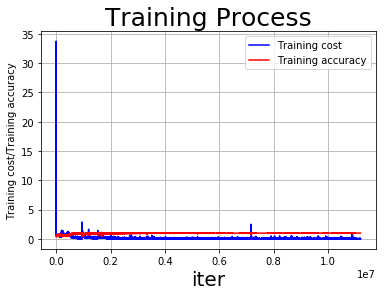

In [16]:
#绘图相关变量和函数,画图是对每个batch的cost和acc画图，最后输出epoch的acc
Train_iter=0
Train_iters=[]
Train_costs=[]
Train_batchs_accs=[]#每个batch的acc，画图画的是每个batch的acc
def Draw_training_process(title,iters,costs,accs,label_cost,label_acc):
    plt.title(title,fontsize=25)
    plt.xlabel("iter",fontsize=20)
    plt.ylabel("Training cost/Training accuracy")
    plt.plot(iters,costs,color='blue',label=label_cost)
    plt.plot(iters,accs,color='red',label=label_acc)
    plt.legend()
    plt.grid()
    plt.savefig("/home/aistudio/work/vgg.png")
    plt.show()
#----------------
EPOCH_NUM=100
model_save_dir="work/vgg/"
exe.run(start_program)
for pass_id in range(EPOCH_NUM):
    #进行训练
    if pass_id%25==0 and pass_id>=25:
        #每25个EPOCH后学习率下降
        LEARNING_RATE=LEARNING_RATE/10
    train_correct_num=0#用来计算每个epoch有多少正确的
    
    for batch_id,data_train in enumerate(train_reader()):
        train_cost=exe.run(program=main_program,#运行主程序
                            feed=feeder.feed(data_train),
                            fetch_list=[sum_cost,predict])
        every_batch_correct_num=0#用来计算每个batch有多少正确
        for d in range(BATCH_SIZE):#计算accuracy
            try:
                d_predict=train_cost[1][d]#[1]是125个样本的sigmoid结果，[d]代表第几个sample
                d_label=data_train[d][1]#0是特征值矩阵42*128，1是label
            except Exception as e:
                print("error:"+str(e))
                print("X================")
                print(train_cost)
                
                #print("d="+str(d))
                #print(data_train[d-1][0])
                #print(data_train[d][0])
                #print(data_train[d])
                print(train_cost[1])
            #print(d_predict)
            #print(d_predict.shape)
            #print(d_label)
            '''if abs(d_predict-d_label)<0.5:
                train_correct_num+=1
            '''#输出层size=1时
            #print(d_predict)
            #print('---')
            if (d_predict[0]<=d_predict[1] and d_label==1) or (d_predict[0]>d_predict[1] and d_label==0):
                train_correct_num+=1#用来计算每个epoch有多少正确的
                every_batch_correct_num+=1#用来计算每个batch有多少正确
        Train_iter=Train_iter+BATCH_SIZE
        Train_iters.append(Train_iter)
        Train_costs.append(train_cost[0])
        every_batch_acc=every_batch_correct_num/BATCH_SIZE
        Train_batchs_accs.append(every_batch_acc)#每个batch的acc
        #每100个batch打印一次信息，误差准确率
        #print("检查acc是否一致:我的acc:"+str(every_batch_acc))
        if batch_id%100==0:
            print('pass:',pass_id,' batch:',batch_id,' cost:',train_cost[0])
    train_epochs_acc=train_correct_num/train_num#每个epoch的准确率
    #sum=0
    #for ac in Train_batchs_accs:
    #    sum+=ac
    #result=sum/len(Train_batchs_accs)
    
    
    #print("检查！"+str(result)+"epoch:"+str(train_epochs_acc))
    print("每训练完一个epoch，train_epochs_acc:",train_epochs_acc)
    
    #进行测试
    test_correct_num=0
    for batch_id,data_test in enumerate(test_reader()):
        avg_cost_np=exe.run(program=test_program,
                            feed=feeder.feed(data_test),
                            fetch_list=[sum_cost,predict])
        
        for d in range(BATCH_SIZE):
            d_predict=avg_cost_np[1][d]
            d_label=data_test[d][1]
            '''if abs(d_predict-d_label)<0.5:
                test_correct_num+=1'''
            if (d_predict[0]<=d_predict[1] and d_label==1) or (d_predict[0]>d_predict[1] and d_label==0):
                test_correct_num+=1
    acc=test_correct_num/test_num
    print('acc:',acc)
    if acc>0.98:
        model_save=model_save_dir+str(acc)+"url.model"
        if not os.path.exists(model_save):
            os.makedirs(model_save)
        print('save model to %s'%(model_save))
        fluid.io.save_inference_model(model_save,
                                    ['image'],
                                    [predict],
                                    exe)
model_save=model_save_dir+"final_url.model"
if not os.path.exists(model_save):
    os.makedirs(model_save)
print('save model to %s'%(model_save))
fluid.io.save_inference_model(model_save,['image'],[predict],exe)
print('训练结束！')
Draw_training_process("Training Process",Train_iters,Train_costs,Train_batchs_accs,"Training cost","Training accuracy")

In [19]:
print(Train_costs[0:100])
print("---------------")
print(Train_costs[0:15])

[array([0.7829125], dtype=float32), array([27.647999], dtype=float32), array([22.429405], dtype=float32), array([33.74564], dtype=float32), array([14.699019], dtype=float32), array([17.062876], dtype=float32), array([3.9210467], dtype=float32), array([12.787167], dtype=float32), array([12.235413], dtype=float32), array([6.5469265], dtype=float32), array([1.311299], dtype=float32), array([2.5043178], dtype=float32), array([3.172865], dtype=float32), array([3.0362859], dtype=float32), array([2.567845], dtype=float32), array([1.3064278], dtype=float32), array([0.8717411], dtype=float32), array([0.8176306], dtype=float32), array([1.3559885], dtype=float32), array([1.1313436], dtype=float32), array([1.0256999], dtype=float32), array([0.98900974], dtype=float32), array([0.84946966], dtype=float32), array([0.71820325], dtype=float32), array([0.7521667], dtype=float32), array([0.7695413], dtype=float32), array([0.7114067], dtype=float32), array([0.72675157], dtype=float32), array([0.7046457], 

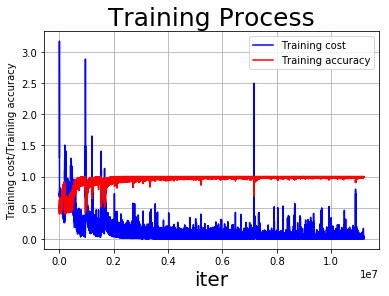

In [27]:
Draw_training_process("Training Process",Train_iters[10:],Train_costs[10:],Train_batchs_accs[10:],"Training cost","Training accuracy")

In [ ]:
print(train_data[])